configuration:
models_ver - insert YOLO version's numbers that the UAP will be trained on.

epsilon, lambda_1, lambda_2 - attack's parameters. more information can be found in the [paper](https://arxiv.org/abs/2205.13618)

BDD_IMG_DIR - a path to the BDD validation set images (or any other wanted dataset)

BDD_LAB_DIR - a path to the BDD validation set labels (or any other wanted dataset)

In [207]:
models_vers = [5] # for example: models_vers = [5] or models_vers = [3, 4, 5]
epsilon = 70
lambda_1 = 1
lambda_2 = 10
seed = 42
patch_size=(640,640)
img_size=(640,640)
batch_size = 8
num_workers = 4
max_labels_per_img = 65
BDD_IMG_DIR = '/Users/coenschoof/miniconda/envs/phantomsponges/BDD100K-to-YOLOV5/bdd_in_YOLOV5_train_newLabels/images/val'
BDD_LAB_DIR = '/Users/coenschoof/miniconda/envs/phantomsponges/BDD100K-to-YOLOV5/bdd_in_YOLOV5_train_newLabels/labels/val'

Load BDD dataset:

In [208]:
import torch
import os
import random
import numpy

from datasets.augmentations1 import train_transform
from datasets.split_data_set_combined import SplitDatasetCombined_BDD

In [209]:
# batch = [(1, 'a'), (2, 'b'), (3, 'c')]

# unzipped = zip(*batch)

# numbers, letters = unzipped

# print(numbers)  # Output: (1, 2, 3)
# print(letters)  # Output: ('a', 'b', 'c')

#dus ipv [(tensor, array, string), (tensor, array, string), (tensor, array, string)] hebben we
# train_loader[0] bevat 8 images
# train_loader[1] bevat alle labels per voor 8 images
# train_loader[2] bevat paths naar 8 images
def collate_fn(batch):
    return tuple(zip(*batch))

def set_random_seed(seed_value, use_cuda=True):
    numpy.random.seed(seed_value)  # cpu vars
    torch.manual_seed(seed_value)  # cpu  vars
    random.seed(seed_value)  # Python
    os.environ['PYTHONHASHSEED'] = str(seed_value)  # Python hash buildin
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)  # gpu vars
        torch.backends.cudnn.deterministic = True  # needed
        torch.backends.cudnn.benchmark = False

In [210]:
split_dataset = SplitDatasetCombined_BDD(
            img_dir= BDD_IMG_DIR,
            lab_dir= BDD_LAB_DIR,
            max_lab=max_labels_per_img,
            img_size=img_size,
            transform=train_transform,
            collate_fn=collate_fn)

In [211]:
#train_loader en val_loader 

#train loader bevat een tuple van 3, elk element van de tuple bevat 8 samples (8 samples maakt 1 batch)
#De tuple bestaat uit het volgende:
    #[0] = de image met size (3,640,640)
    #[1] = de bounding boxes met size (x, 5) (5 bestaat uit class, x, y, x, y)
        #lijkt nergens gebruikt te worden
    #[2] = de naam van de image (e.g. 'c98258a4-54a47ff2.jpg')  

    #HEB IK AL DEZE INFORMATIE OOK NODIG WANNEER IK WIL TESTEN OP PASCAL/MTSD? converten is een pain
        #WORDT [2] ERGENS GEBRUIKT? IK WEET DAT [1] NERGENS GEBRUIKT WORDT
train_loader, val_loader, test_loader = split_dataset(val_split=0.1,
                                                      shuffle_dataset=True,
                                                      random_seed=seed,
                                                      batch_size=batch_size,
                                                      ordered=False,
                                                      collate_fn=collate_fn)

In [19]:
# from torch.utils.data import DataLoader, SubsetRandomSampler, RandomSampler

# sampler = RandomSampler([0,1,2,3])

# for i in sampler:
#     print(i)

In [20]:
# next(iter(train_loader))

In [21]:
# clean_xyxy_out = torch.tensor([[0.0156, 0.0312, 0.0781, 0.1094]])

# patch_xyxy_out = torch.tensor([
#                         [10/640, 20/640, 50/640, 70/640],  # [x1, y1, x2, y2]
#                         [30/640, 40/640, 80/640, 100/640],
#                         [60/640, 70/640, 120/640, 160/640],
#                     ])

# #intersect(patch_xyxy_out, clean_xyxy_out)

# torch.min(clean_xyxy_out[:, 2:].unsqueeze(1).expand(1, 3, 2), patch_xyxy_out[:, 2:].unsqueeze(0).expand(1, 3, 2))

In [22]:
# import torch
# import torchvision.transforms as transforms
# from PIL import Image

# # Load the image using PIL
# image = Image.open('/Users/coenschoof/miniconda/envs/phantomsponges/BDD100K-to-YOLOV5/bdd100k/images/100k/val/b1c9c847-3bda4659.jpg')

# # Define the transformations to apply to the image
# transform = transforms.ToTensor()

# # Apply the transformations to convert the image to a tensor
# tensor = transform(image)

In [23]:
# model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

# # Inference
# results = model(tensor.unsqueeze(0))

In [24]:
# results.size()

In [25]:
# for (img_batch, lab_batch, _) in val_loader:
#     print(torch.stack(img_batch).size())
#     break


create UAP:

In [6]:
import numpy
from attack.uap_phantom_sponge import UAPPhantomSponge

torch.cuda.empty_cache()

patch_name = r"yolov"
for ver in models_vers:
  patch_name += f"_{ver}"
patch_name += f"_epsilon={epsilon}_lambda1={lambda_1}_lambda2={lambda_2}"

uap_phantom_sponge_attack = UAPPhantomSponge(patch_folder=patch_name, 
                                             train_loader=train_loader, 
                                             val_loader=val_loader, 
                                             epsilon = epsilon, 
                                             lambda_1=lambda_1, 
                                             lambda_2=lambda_2, 
                                             #epochs=7,#stond hier voorheen nog niet
                                             patch_size=patch_size, 
                                             models_vers=models_vers)
adv_img = uap_phantom_sponge_attack.run_attack()

CUDA Available:  False
local_yolos/yolov5/weights/yolov5s.pt


Fusing layers... 
[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.
yolov5s summary: 270 layers, 7235389 parameters, 0 gradients, 16.6 GFLOPs


Epoch:  0
Transformed Image Shape: torch.Size([3, 640, 640])
Transformed Image Shape: torch.Size([3, 640, 640])
Transformed Image Shape: torch.Size([3, 640, 640])
Transformed Image Shape: torch.Size([3, 640, 640])
Transformed Image Shape: torch.Size([3, 640, 640])
Transformed Image Shape: torch.Size([3, 640, 640])
Transformed Image Shape: torch.Size([3, 640, 640])
Transformed Image Shape: torch.Size([3, 640, 640])
saving png of current patch at epoch: 0, batch: 0/169...


KeyboardInterrupt: 

# CODE FOR EVALUATION

In [212]:
import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np
from local_yolos.yolov5.models.experimental import attempt_load
from local_yolos.yolov5.utils.general import non_max_suppression
from torchvision import transforms
from local_yolos.yolov5.utils.metrics import box_iou
from local_yolos.yolov5.utils.plots import Annotator
import time
from tqdm import tqdm

In [213]:
# Load the YOLOv5 model
model = attempt_load(weights='yolov5s.pt').eval()

Fusing layers... 


yolov5s.pt


yolov5s summary: 270 layers, 7235389 parameters, 0 gradients, 16.6 GFLOPs


In [214]:
def perturb_img(img_name, change_aspect_ratio = True, output_type = "torch"):
    image_path = "/Users/coenschoof/miniconda/envs/phantomsponges/BDD100K-to-YOLOV5/bdd_in_YOLOV5_train_newLabels/images/val/" + img_name
    image = Image.open(image_path)
    image = image.resize((640, 640))
    transform = transforms.Compose([transforms.ToTensor()])
    clean_img = transform(image)

    # Load the image using PIL
    patch_path =  "/Users/coenschoof/miniconda/envs/phantomsponges/PhantomSponges/final_patch.png"
    patch = Image.open(patch_path)
    patch = transform(patch)

    perturbed_img = torch.clamp(clean_img + patch, 0, 1)

    # Assuming you have a torch tensor named torch_image
    # You can resize the tensor to (H, W, C) shape using transpose and multiply by 255 (if it's not already in the correct range)
    #pil_image = transforms.ToPILImage()(result.squeeze().cpu() * 255)
    tensor_min = torch.min(perturbed_img)
    tensor_max = torch.max(perturbed_img)
    normalized_tensor = (perturbed_img - tensor_min) / (tensor_max - tensor_min)

    # Convert the normalized tensor to a PIL image
    pil_image = transforms.ToPILImage()(normalized_tensor.squeeze().cpu())
    if change_aspect_ratio:
        random_scale_w = random.uniform(0.7, 0.9) #1.5, 3
        #random_scale_h = random.uniform(1, 2.5)
        width = int(640 * random_scale_w)
        width = (width // 32) * 32 #ensures that the new width is a multiple of 32, otherwise the model does not work
        height = 640 #height = int(640 * random_scale_h)
        height = (height // 32) * 32
        pil_image = pil_image.resize((width, height))

    if output_type == "torch":
        perturbed_image = transform(pil_image)
    elif output_type == "numpy":
        perturbed_image = np.array(pil_image)
    elif output == "pil":
        pass
    else:
        print("Unsupported output type provided!")

    return(perturbed_image)

In [14]:
# image_names = []
# for image_np, _, image_name in tqdm(test_loader):
#     image_names.append(image_name[0])

100%|██████████| 500/500 [00:07<00:00, 66.61it/s]


In [20]:
# for img_name in tqdm(image_names):
#     other_image = perturb_img(img_name, change_aspect_ratio = False, output_type = "torch").unsqueeze(0)
#     pil_image = transforms.ToPILImage()(other_image.squeeze())
#     pil_image.save(f"clean_images/{img_name}.jpg")

100%|██████████| 500/500 [00:28<00:00, 17.55it/s]


torch.Size([1, 3, 640, 544])


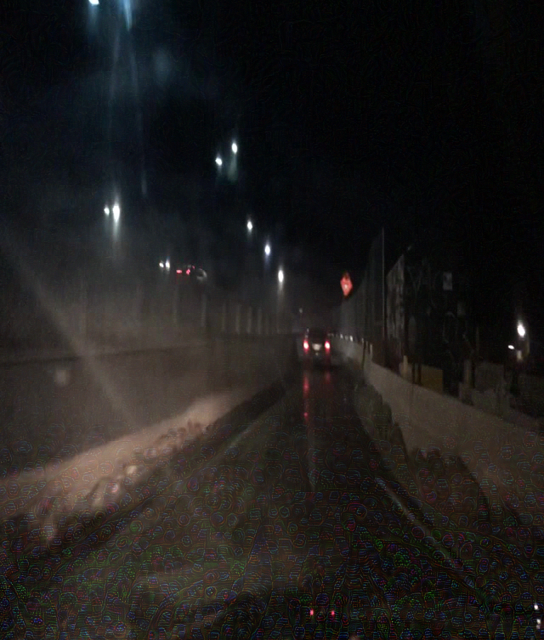

In [95]:
other_image = perturb_img('c7776076-95aab855.jpg', change_aspect_ratio = True, output_type = "torch").unsqueeze(0)
print(other_image.shape)
pil_image = transforms.ToPILImage()(other_image.squeeze())
display(pil_image)

In [96]:
model(other_image)

(tensor([[[5.74027e+00, 4.50167e+00, 1.08214e+01,  ..., 2.01581e-03, 6.80842e-04, 1.37030e-03],
          [1.24691e+01, 4.73595e+00, 2.49085e+01,  ..., 2.22791e-03, 9.34321e-04, 1.72253e-03],
          [1.76583e+01, 4.69327e+00, 2.95009e+01,  ..., 1.78221e-03, 8.23242e-04, 1.47785e-03],
          ...,
          [4.58842e+02, 6.17338e+02, 1.47927e+02,  ..., 6.49686e-03, 7.21431e-04, 1.00500e-03],
          [4.92840e+02, 6.21486e+02, 1.41151e+02,  ..., 3.78686e-03, 7.51774e-04, 9.83635e-04],
          [5.22983e+02, 6.24360e+02, 1.53508e+02,  ..., 4.08493e-03, 6.60140e-04, 9.77951e-04]]]),
 [tensor([[[[[ 4.42131e-01,  1.25582e-01,  8.05669e-02,  ..., -6.20472e+00, -7.29150e+00, -6.59135e+00],
             [ 1.17415e-01,  1.84508e-01,  1.31964e+00,  ..., -6.10446e+00, -6.97476e+00, -6.36224e+00],
             [-6.03054e-01,  1.73754e-01,  1.80528e+00,  ..., -6.32812e+00, -7.10144e+00, -6.51569e+00],
             ...,
             [ 7.98791e-01,  1.48105e-01,  1.82271e+00,  ..., -6.33775e+0

(640, 448, 3)


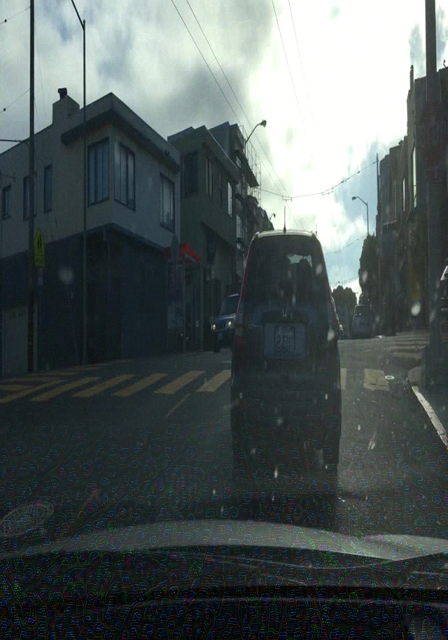

In [73]:
some_image = perturb_img('be6fd6ac-35af61fd.jpg', change_aspect_ratio = True, output_type = "numpy")
print(some_image.shape)
pil_image = transforms.ToPILImage()(some_image.squeeze())
display(pil_image)

In [215]:
def compute_recall(box_iou_output):
    true_pos = 0
    for clean_detection in box_iou_output:
        if clean_detection[clean_detection > 0.45].nelement() != 0:
            true_pos += 1

    return true_pos / box_iou_output.size()[0]

In [216]:
def add_bbs(image, xyxys):
    numpy_clean_img = image.squeeze().permute(1, 2, 0).cpu().numpy()
    annotator = Annotator(np.ascontiguousarray(numpy_clean_img))
    
    for xyxy in xyxys:
        annotator.box_label(xyxy)
    annotator_results = annotator.result()
    annotator_results = (annotator_results * 255).astype(np.uint8)
    pil_image = Image.fromarray(annotator_results)

    return pil_image

In [217]:
def scale_bbs(orig_dims, target_dims, orig_xyxy):
    # Original image dimensions (640x1200)
    original_height, original_width = orig_dims[2:]

    # Target image dimensions (640x640)
    target_height, target_width = target_dims[2:]

    # Calculate scaling factors for x and y dimensions
    x_scale = target_width / original_width
    y_scale = target_height / original_height

    # Scale the coordinates of the bounding boxes
    scaled_bounding_boxes = orig_xyxy.clone().detach()  # Create a copy to preserve the original data
    scaled_bounding_boxes[:, 0] *= x_scale  # Scale x (left)
    scaled_bounding_boxes[:, 1] *= y_scale  # Scale y (top)
    scaled_bounding_boxes[:, 2] *= x_scale  # Scale x2 (right)
    scaled_bounding_boxes[:, 3] *= y_scale  # Scale y2 (bottom)

    return scaled_bounding_boxes

In [91]:
def evaluate_results(loader = test_loader, Tconf = 0.25, Tiou = 0.45, max_det_pert=300, max_det_clean=300):
    all_total_times = []
    all_nms_times = []
    all_num_bbs_before_nms = []
    all_recalls = []

    for image_np, _, image_name in tqdm(loader):
        perturbed_img = perturb_img(image_name[0],change_aspect_ratio = True).unsqueeze(0)
        #print(image_name[0])
        #print("perturbed img size: ", perturbed_img.shape)
        clean_img = image_np[0].unsqueeze(0)
        #print("clean img size: ", clean_img.shape)

        total_times_single_img = []
        nms_times_single_img = []

        #for i in range(30):
        start_time_1 = time.time() * 1000
        output_perturbed = model(perturbed_img)[0]
        start_time_2 = time.time() * 1000
        keep_perturbed = non_max_suppression(output_perturbed, Tconf, Tiou, classes=None,max_det=max_det_pert)
        #print(len(keep_perturbed[0]))
        end_time = time.time() * 1000 
        total_time = end_time - start_time_1
        nms_time = end_time - start_time_2
        total_times_single_img.append(total_time)
        nms_times_single_img.append(nms_time)
        
        #total_time = sum(total_times_single_img) / len(total_times_single_img)
        #nms_time = sum(nms_times_single_img) / len(nms_times_single_img)

        output_clean = model(clean_img)[0]
        keep_clean = non_max_suppression(output_clean, Tconf, Tiou, classes=None,max_det=max_det_clean)

        num_bbs_before_nms_mask = output_perturbed[..., 4] > Tconf 
        num_bbs_before_nms = num_bbs_before_nms_mask.sum().item()   #F(C')

        clean_xyxy = keep_clean[0][:,0:4]
        #print(clean_xyxy)

        # with_bbs = add_bbs(clean_img, clean_xyxy)
        # display(with_bbs)
        perturbed_xyxy = keep_perturbed[0][:,0:4]

        # with_bbs = add_bbs(perturbed_img, perturbed_xyxy)
        # display(with_bbs)


        #scaled_perturbed_xyxy = scale_coords(perturbed_img.shape[2:], perturbed_xyxy, clean_img.shape[2:]).round()
        scaled_perturbed_xyxy = scale_bbs(orig_dims=perturbed_img.shape, target_dims=clean_img.shape, orig_xyxy = perturbed_xyxy)

        # resized_perturbed_img = F.interpolate(perturbed_img, size=(640,640), mode='bilinear', align_corners=False)
        # with_bbs = add_bbs(resized_perturbed_img, scaled_perturbed_xyxy)
        # display(with_bbs)

        box_iou_output = box_iou(clean_xyxy, scaled_perturbed_xyxy)
        
        #check if its the case that there aren't any clean detections
        #in that case, skip computing the recall
        #"the number of original objects detected in the perturbed image"
        #if there aren't any original objects, no recall can be calculated, thus we skip
        if clean_xyxy.nelement() != 0:
            recall = compute_recall(box_iou_output)
            all_recalls.append(recall)


        all_total_times.append(total_time)
        all_nms_times.append(nms_time)
        all_num_bbs_before_nms.append(num_bbs_before_nms)
        
    avg_total_time = sum(all_total_times) / len(all_total_times)
    avg_nms_time = sum(all_nms_times) / len(all_nms_times)
    avg_num_bbs_before_nms = sum(all_num_bbs_before_nms) / len(all_num_bbs_before_nms)
    avg_recall = sum(all_recalls) / len(all_recalls)

    return round(avg_total_time, 1), round(avg_nms_time, 1), round(avg_num_bbs_before_nms), round(avg_recall, 3)

results = evaluate_results()

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [08:01<00:00,  1.04it/s]


In [92]:
results

#dit zijn de results met resize breedte tussen de 0.7 en 0.9
#super! De inference time is omlaag gegaan, de nms time is 5 keer zo klein, het aantal bbs voor nms is superklein, en de recall is prima

(397.3, 0.8, 207, 0.667)

In [78]:
results

#dit zijn de results met resize breedte tussen de 0.5 en 0.9
#het lijkt te kloppen dat kleinere plaatjes leidt tot een lagere inference time, helaas is de recall ook omlaag gegaan
#smallere range proberen


(338.9, 0.6, 116, 0.531)

In [16]:
results

#HET WERKT!!!!!!
#WAAROM IS DE INFERENCE TIME ZO LANG? MISSCHIEN OMDAT DE PLAATJES GROTER ZIJN? (MEER WAARDEN TE VERWERKEN DOOR HET MODEL)
#PROBEER TE RUNNEN MET EEN RESIZE FACTOR <1
#MSS OOK PROBEREN TE RUNNEN MET EEN RESIZED HOOGTE IPV BREEDTE

(1436.1, 1.8, 247, 0.72)

In [714]:
#dit zijn de resultaten zonder resize
results

(504.1, 4.3, 4499, 0.656)

# New loss term experiments

In [222]:
import torchvision
from local_yolos.yolov5.utils.general import non_max_suppression, xyxy2xywh

In [223]:
other_image_output = model(other_image)

In [234]:
def bboxes_area(output_clean, output_patch, conf_thres=0.25):

    def xywh2xyxy(x):
        # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
        y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
        y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
        y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
        y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
        y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
        return y

    t_loss = 0.0
    preds_num = 0

    xc_patch = output_patch[..., 4] > conf_thres
    not_nan_count = 0

    # For each img in the batch
    for (xi, x), (li, l) in (zip(enumerate(output_patch), enumerate(output_clean))):  # image index, image inference
        print(xi)
        x1 = x[xc_patch[xi]]  #neem alle BBs waarvan de confidence hoger is dan 0.25
        #x1 heeft nu een size van [21420, 85], (batch_size, num_predictions, pred_elements)
        #pred_elements is 85 lang, de eerste 4 zijn BB coords, 5 is conf score, overige 80 zijn class probs
        #hieronder worden dus de class probs vermenigvuldigd met de conf score
        x2 = x1[:, 5:] * x1[:, 4:5]  
        #print(x2.shape)

        # Box (center x, center y, width, height) to (x1, y1, x2, y2)
        box_x1 = xywh2xyxy(x1[:, :4])
        #print(box_x1.shape)

        min_wh, max_wh = 2, 4096  # (pixels) minimum and maximum box width and height

        #neemt over alle boxes de hoogste confwaarden, en de index daarvan (dus 1 confwaarde per box)
        conf_x1, j_x1 = x2.max(1, keepdim=True)
        #concateneer de xyxy waarden met de hoogste conf, en de daarbij horende index van de conf
        #indexeer die vervolgens weer met waar de conf > 0.25
        #print(torch.cat((box_x1, conf_x1, j_x1.float()), 1).shape)
        #print(torch.cat((box_x1, conf_x1, j_x1.float()), 1)[conf_x1.view(-1) > conf_thres].shape)
        x1_full = torch.cat((box_x1, conf_x1, j_x1.float()), 1)[conf_x1.view(-1) > conf_thres]
        #print(x1_full.shape)
        boxes_x1 = x1_full[:, :4] 

        iou = box_iou(boxes_x1, boxes_x1)
        mask = torch.triu(torch.ones(iou.shape[0], iou.shape[1]), diagonal=1)
        upper_triangular_tensor = iou[mask.bool()]
        print(upper_triangular_tensor)
        print(upper_triangular_tensor.sum().item())

        #calculate bboxes' area avg
        bboxes_x1_wh = xyxy2xywh(boxes_x1)[:, 2:]
        bboxes_x1_area = bboxes_x1_wh[:, 0] * bboxes_x1_wh[:, 1]
        img_loss = bboxes_x1_area.mean() / (640 * 640)
        if not torch.isnan(img_loss):
            t_loss += img_loss
            not_nan_count += 1

    if not_nan_count == 0:
        t_loss_f = torch.tensor(torch.nan)
    else:
        t_loss_f = t_loss / not_nan_count

    return t_loss_f

In [235]:
bboxes_area(other_image_output[0], other_image_output[0])

0
tensor([0.00000, 0.00000, 0.00000,  ..., 0.98389, 0.00000, 0.00000])
981.2411499023438


tensor(0.00045)

In [131]:
other_image_output[0].shape

torch.Size([1, 21420, 85])

In [138]:
other_image_output[0].max(1, keepdim=True)[1]

tensor([[[ 3739,  5389, 21326, 21292, 10158,  8146, 20631, 16081,  3100, 21391, 21055, 21279, 20272, 21393,  2267,  8674, 13371, 19177, 14061,   443, 20424, 18575, 20108,  4243, 20425, 21166, 21166, 11156, 19123, 11911, 15709,   364,   354, 18519,  2155, 13238,  7663,  1433,  1004,  7598,  1366, 13624,  7663, 13106,
           2749, 20743,  2817,   403, 11440,  8256, 13697,   532,  4065, 18904,  3524,  1694,   645,  2949, 21324, 15584, 18842, 14130, 21386, 20325, 21372, 14195, 14408, 13731, 11350,  9820, 17185, 13687,  5451, 13718, 19849, 21106, 13822,  8278,   474,   582,  8191, 19047, 10608, 17719,   422]]])